In [1]:
import matplotlib.pyplot as plt
from time import time
from collections import deque
from matplotlib.patches import Polygon

In [2]:
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.edges = set()
    
    def __hash__(self):
        return hash(self.x)*3 + hash(self.y)*5
    
    def __eq__(self,other):
        if not isinstance(other,Point):
            return False
        return self.x == other.x and self.y == other.y
    
    def __str__(self):
        return "P:("+str(self.x)+","+str(self.y)+")"
class Edge:
    def __init__(self,origin):
        self.origin = origin
        self.next = None
        self.prev = None
        self.face = None
        self.twin = None
        
    def __hash__(self):
        return hash(self.origin)*7 + hash(self.twin.origin)
    
    def __eq__(self,other):
        if not isinstance(other,Edge):
            return False
        return self.origin == other.origin and self.twin.origin == other.twin.origin
    
    def __str__(self):
        return "E: "+ str(self.origin) + " -> " + str(self.twin.origin)
class Face:
    def __init__(self,e1,e2,e3):
        self.edges = set([e1,e2,e3])
        self.visited = False
    
    def __hash__(self):
        result = 1
        for e in self.edges:
            result*=hash(e)
        return result
    
    def __eq__(self,other):
        if not isinstance(other,Face):
            return False
        if len(self.edges) != len(other.edges):
            return False
        for e in self.edges:
            if e not in other.edges:
                return False
        return True
    
    def __str__(self):
        string = "__"
        for e in self.edges:
            string = string + str(e) + " _|_ "
        return "F: " + string

    
def orient(edge, p):
    A = edge.origin
    B = edge.twin.origin
    wynik = A.x*B.y + B.x*p.y + p.x*A.y - A.y*B.x - B.y*p.x - A.x*p.y
    if abs(wynik)<10**(-12):
        return 0
    return wynik

def pointInCircle(field, p):
    first = list(field.edges)[0]
    edges = [first,first.next,first.prev]
    #print("CONDITION")
    
    points = [edges[i].origin for i in range(3)]
    #for i in points:
    #    print(i,end = ' ')
    #print('')
    result = 0
    for i in range(3):
        result += (points[i].x - p.x)*(points[(i+1)%3].y - p.y)*(points[(i+2)%3].x**2 - p.x**2 + points[(i+2)%3].y**2 - p.y**2)
        result -= (points[i].x - p.x)*(points[(i+2)%3].y - p.y)*(points[(i+1)%3].x**2 - p.x**2 + points[(i+1)%3].y**2 - p.y**2)
    if abs(result)<10**(-12):
        return 0
    return result

def create_edge(p1,p2):
        e1 = Edge(p1)
        e2 = Edge(p2)
        e1.twin=e2
        e2.twin=e1
        p1.edges.add(e1)
        p2.edges.add(e2)
        return e1
    
def connect_edges(prev,e):
    e.prev = prev
    prev.next = e


In [3]:
def read_from_file(path):
    P = []
    read = open(path, 'r')
    for line in read:
        P.append(list(map(float, line.split())))
    return P

In [4]:
def draw_figure(L):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    for i in range(len(L)):
        plt.plot([L[i-1][0],L[i][0]],[L[i-1][1],L[i][1]],color = "blue")
        plt.plot(L[i][0], L[i][1], '.',color = 'red')

def draw_traingulation(FACES):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    for f in FACES:
        E = list(f.edges)[0]
        e = E
        
        while True:
            plt.plot([e.origin.x,e.twin.origin.x],[e.origin.y,e.twin.origin.y],color = "blue")
            plt.plot(e.origin.x,e.origin.y,'.',color = 'red',markersize = 10)
            e = e.next
            if e == E:
                break
    return ax
    
def draw_edges(edges):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.set_xlim([-1, 7])
    ax.set_ylim([-0.5, 2.5])
    for e in edges:
        plt.plot([e.origin.x,e.twin.origin.x],[e.origin.y,e.twin.origin.y],color = "blue")
        
    plt.show()

In [9]:
class Delunay:
    def __init__(self,T):
        ## 1
        self.FACES = set()
        self.Points = [Point(p[0],p[1]) for p in T]
        
        min_x = min([p.x for p in self.Points])
        min_y = min([p.y for p in self.Points])
        max_x = max([p.x for p in self.Points])
        max_y = max([p.y for p in self.Points])
        self.middle = Point((max_x+min_x)/2,(max_y+min_y)/2)
        width = max_x - min_x
        min_x -= width*0.1
        max_x += width*0.1
        height = max_y - min_y
        min_y -= height*0.1
        max_y += height*0.1
        A = Point(min_x,min_y)
        B = Point(max_x,min_y)
        C = Point(max_x,max_y)
        D = Point(min_x,max_y)
        self.startingPoints = [A,B,C,D]
        ## 2
        e1 = create_edge(A,B)
        e2 = create_edge(B,C)
        e3 = create_edge(C,A)
        T = [e1,e2,e3]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e2.twin,e1.twin)
        # ---------------
        #self.create_face(T)
        self.middleFace = self.create_face(T)
        # ---------------
        e4 = create_edge(C,D)
        e5 = create_edge(D,A)
        T = [e3.twin,e4,e5]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e1.twin,e5.twin)
        connect_edges(e5.twin,e4.twin)
        connect_edges(e4.twin,e2.twin)
        
        self.create_face(T)
    
    def create_face(self,edges):
        face = Face(edges[0],edges[1],edges[2])
        for i in range(3):
            edges[i].face = face
        self.FACES.add(face)
        return face
    
    def pointInFace(self,face,p):
        for e in face.edges:
            if orient(e, p)<0:
                return False
        return True
        
    def findPoint(self,p):
        face = self.middleFace  #  na później
        #face = list(self.FACES)[0]
        while True:
            flag = True
            for e in face.edges:
                if orient(e, p)<0:
                    face = e.twin.face
                    flag = False
                    break
            if flag:
                break
        return face
    
    # Face musi miec pole VISITED
    def conditionFaces(self,p, face):
        faces = set()
        for f in self.FACES:
            f.visited = False
        Q = deque()
        Q.append(face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            face.visited = True
            if pointInCircle(face, p)>=0:
                faces.add(face)
                for e in face.edges:
                    if e.twin.face!=None and not e.twin.face.visited:
                        Q.append(e.twin.face)
        return faces
                
    #
    def combineFaces(self,faces):
        edges = set()
        for face in faces:
            if face == self.middleFace:
                self.middleFace = None
            edges.update(face.edges)
            self.FACES.remove(face)
        while len(edges) > 0:
            e = edges.pop()
            #print(e,e.twin in edges)
            if e.twin in edges:
                # usuwanie krawedzi
                e.twin.prev.next = e.next
                e.next.prev = e.twin.prev
                e.twin.next.prev = e.prev
                e.prev.next = e.twin.next
                edges.remove(e.twin)
                e.origin.edges.remove(e)
                e.twin.origin.edges.remove(e.twin)
            else:
                firstEdge = e
        return firstEdge
        
    #
    #face mhsi miec KRAWEDZIE, bo inaczej nie vedzie sie dalo dojsc z punktu do krawedzi (nie bedzie jednoznacznego okreslenia w ktore krawiedzie sa)
    def add_point(self,p): #zmiana, lecimy druga metoda
        plt.show()
        face = self.findPoint(p)
        
        faces = self.conditionFaces(p,face) # to ma być set zwrocony

        firstEdge=self.combineFaces(faces) # a tutaj jedna krawędź
        lastEdge = firstEdge.prev
            
        q = firstEdge.origin
        e = create_edge(p,q)
        e.next = firstEdge
        e.twin.prev = lastEdge #obaczymy czy trgo nie robie pozniei
        lastEdge.next = e.twin
        firstEdge.prev = e
        f = firstEdge.next
        while True:
            q = f.origin
                #podczepianie krawedzi
            e = create_edge(p,q)
            e.next = f
            e.twin.prev = f.prev 
            e.twin.next= e.twin.prev.prev
            e.twin.next.prev = e.twin     ########## TO OSTATNIE DOPISAŁEM
            #e.twin.next.prev = e.twin
            f.prev.next = e.twin
            f.prev = e
                #podczepianie sciany
            et = e.twin
            T = [et, et.next, et.prev]
            newFace = self.create_face(T)
            if self.middleFace == None:
                if self.pointInFace(newFace,self.middle):
                    self.middleFace = newFace
            if f == lastEdge:
                break
            f = f.next
        e.prev = lastEdge.next 
        e.prev.next = e
        T = [e, e.next, e.prev]
        
        newFace = self.create_face(T)
        if self.middleFace == None:
            if self.pointInFace(newFace,self.middle):
                self.middleFace = newFace
        
    def addPoints(self,steps):
        for p in self.Points: 
            self.add_point(p)
            if steps:
                draw_traingulation(self.FACES)
            
    def addPointsRandom(self,steps):
        POINTS = set(self.Points)
        while len(POINTS)>0:
            self.add_point(POINTS.pop())
            if steps:
                draw_traingulation(self.FACES)
                plt.show()
                
    # ----------------------
    
    def intersecting_edge(self,face,p,pnext):
        C,D = p, pnext
        edge2 = Edge(C)
        edge2.twin = Edge(D)
        for edge in face.edges:
            A = edge.origin
            B = edge.twin.origin
            if orient(edge,C)*orient(edge,D) > 0:
                continue
            if orient(edge2,A)*orient(edge2,B) <= 0:
                return edge
        return False
            
    def regainEdges(self,steps = False):
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            #print("p i next:  ",p,pnext)
            flag = False
            for e in p.edges:
                if e.twin in pnext.edges:
                    flag = True
                    break
            if not flag:
                
                dx = pnext.x - p.x
                dy = pnext.y - p.y
                lenght = dx**2+dy**2
                t = 10**(-8)
                pierw = 1
                while pierw*pierw<lenght:
                    pierw*=10
                    t/=10
                firstSearchPoint = Point(p.x+t*dx,p.y+t*dy)
                face = self.findPoint(firstSearchPoint)
                br = False
                while not br:
                    int_e = self.intersecting_edge(face, firstSearchPoint, pnext)
                    if int_e.face == self.middleFace or int_e.twin.face== self.middleFace:
                        self.middleFace = None
                    self.FACES.remove(int_e.face)
                    self.FACES.remove(int_e.twin.face)
                    
                    # usuniecie z punktow
                    int_e.origin.edges.remove(int_e)
                    int_e.twin.origin.edges.remove(int_e.twin)
                    
                    # usuniecie z sasiednich krawedzi
                    int_e.next.prev = int_e.twin.prev
                    int_e.prev.next = int_e.twin.next
                    int_e.twin.prev.next = int_e.next
                    int_e.twin.next.prev = int_e.prev

                    #tworzenie nowej
                    e1 = create_edge(int_e.prev.origin,int_e.twin.prev.origin)
                    
                    #podłaczanie
                    e1.origin.edges.add(e1)
                    e1.twin.origin.edges.add(e1.twin)
                    
                    # krawedzie
                    int_e.next.next = e1
                    e1.prev = int_e.next
                    int_e.twin.prev.prev = e1
                    e1.next = int_e.twin.prev
                    int_e.prev.prev = e1.twin
                    e1.twin.next = int_e.prev
                    int_e.twin.next.next = e1.twin
                    e1.twin.prev = int_e.twin.next
                    face1 = self.create_face([e1,e1.next,e1.prev])
                    face2 = self.create_face([e1.twin,e1.twin.next,e1.twin.prev])
                    if self.middleFace == None:
                        if self.pointInFace(face1,self.middle):
                            self.middleFace = face1
                        else:
                            self.middleFace = face2
                    face = e1.face
                    if self.intersecting_edge(face, firstSearchPoint, pnext) == False:
                        face = e1.twin.face
                    for e in p.edges:
                        if e.twin in pnext.edges:
                            br = True
                            break
                    if steps:
                        draw_traingulation(self.FACES)
                        plt.plot([int_e.origin.x,int_e.twin.origin.x],[int_e.origin.y,int_e.twin.origin.y],color = 'red')
                        plt.plot([e1.origin.x,e1.twin.origin.x],[e1.origin.y,e1.twin.origin.y],color = 'green')
                        plt.plot([p.x,pnext.x],[p.y,pnext.y],'--',color = "black")
                        plt.show()
                    
    def eraseOuterLayer(self,steps):
        def safe_create_edge(p,pnext):
            e1 = Edge(p)
            e2 = Edge(pnext)
            e1.twin = e2
            e2.twin = e1
            return e1
        EDGES = set()
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            e = safe_create_edge(p,pnext)
            EDGES.add(e)
        point = self.Points[0]
        for f in self.FACES:
            f.visited = False
        for e in point.edges:
            if e in EDGES:
                break
        Q = deque()
        Q.append(e.face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            if steps:
                ax = draw_traingulation(self.FACES)
                for f in self.FACES:
                    if f.visited:
                        pts = [[edge.origin.x,edge.origin.y] for edge in f.edges]
                        p = Polygon(pts, closed=False)
                        ax.add_patch(p)
                for edge in EDGES:
                    plt.plot([edge.origin.x,edge.twin.origin.x],[edge.origin.y,edge.twin.origin.y],linewidth = 5,color = 'black')
                pts = [[edge.origin.x,edge.origin.y] for edge in face.edges]
                p = Polygon(pts, closed=False,color = 'red')
                ax.add_patch(p)
                plt.show()
            face.visited = True
            for e in face.edges:
                if e not in EDGES and not e.twin.face.visited:
                    Q.append(e.twin.face)
        AllFaces = list(self.FACES)
        for face in AllFaces:
            #print(face)
            if face.visited:
                continue
            # usuwanie sciany
            for e in face.edges:
                e.next = None
                e.prev = None
                e.face = None
            self.FACES.remove(face)
        
            
        
        
    def start(self,Steps,random):
        if Steps:
            draw_traingulation(self.FACES)
            print("ADD")
        if random:
            self.addPointsRandom(steps = Steps)
        else:
            self.addPoints(steps = Steps)
        if Steps:
            print("REGAIN")
        self.regainEdges(steps = Steps)
        if Steps:
            draw_traingulation(self.FACES)
            plt.show()
            print("ERASE")
        self.eraseOuterLayer(steps = Steps)
        draw_traingulation(self.FACES)
        plt.show()

In [21]:
class Delunay:
    def __init__(self,T):
        ## 1
        self.FACES = set()
        self.Points = [Point(p[0],p[1]) for p in T]
        
        min_x = min([p.x for p in self.Points])
        min_y = min([p.y for p in self.Points])
        max_x = max([p.x for p in self.Points])
        max_y = max([p.y for p in self.Points])
        self.middle = Point((max_x+min_x)/2,(max_y+min_y)/2)
        width = max_x - min_x
        min_x -= width*0.1
        max_x += width*0.1
        height = max_y - min_y
        min_y -= height*0.1
        max_y += height*0.1
        A = Point(min_x,min_y)
        B = Point(max_x,min_y)
        C = Point(max_x,max_y)
        D = Point(min_x,max_y)
        self.startingPoints = [A,B,C,D]
        ## 2
        e1 = create_edge(A,B)
        e2 = create_edge(B,C)
        e3 = create_edge(C,A)
        T = [e1,e2,e3]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e2.twin,e1.twin)
        # ---------------
        self.middleFace = self.create_face(T)
        # ---------------
        e4 = create_edge(C,D)
        e5 = create_edge(D,A)
        T = [e3.twin,e4,e5]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e1.twin,e5.twin)
        connect_edges(e5.twin,e4.twin)
        connect_edges(e4.twin,e2.twin)
        
        self.create_face(T)
    
    def create_face(self,edges):
        face = Face(edges[0],edges[1],edges[2])
        for i in range(3):
            edges[i].face = face
        self.FACES.add(face)
        return face
    
    def pointInFace(self,face,p):
        for e in face.edges:
            if orient(e, p)<0:
                return False
        return True
        
    def findPoint(self,p):
        face = self.middleFace  #  na później
        while True:
            flag = True
            for e in face.edges:
                if orient(e, p)<0:
                    face = e.twin.face
                    flag = False
                    break
            if flag:
                break
        return face
    
    # Face musi miec pole VISITED
    def conditionFaces(self,p, face):
        faces = set()
        for f in self.FACES:
            f.visited = False
        Q = deque()
        Q.append(face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            face.visited = True
            if pointInCircle(face, p)>=0:
                faces.add(face)
                for e in face.edges:
                    if e.twin.face!=None and not e.twin.face.visited:
                        Q.append(e.twin.face)
        return faces
                
    #
    def combineFaces(self,faces):
        edges = set()
        for face in faces:
            if face == self.middleFace:
                self.middleFace = None
            edges.update(face.edges)
            self.FACES.remove(face)
        while len(edges) > 0:
            e = edges.pop()
            #print(e,e.twin in edges)
            if e.twin in edges:
                # usuwanie krawedzi
                e.twin.prev.next = e.next
                e.next.prev = e.twin.prev
                e.twin.next.prev = e.prev
                e.prev.next = e.twin.next
                edges.remove(e.twin)
                e.origin.edges.remove(e)
                e.twin.origin.edges.remove(e.twin)
            else:
                firstEdge = e
        return firstEdge
        
    #
    #face mhsi miec KRAWEDZIE, bo inaczej nie vedzie sie dalo dojsc z punktu do krawedzi (nie bedzie jednoznacznego okreslenia w ktore krawiedzie sa)
    def add_point(self,p): #zmiana, lecimy druga metoda
        plt.show()
        face = self.findPoint(p)
        
        faces = self.conditionFaces(p,face) # to ma być set zwrocony

        firstEdge=self.combineFaces(faces) # a tutaj jedna krawędź
        lastEdge = firstEdge.prev
            
        q = firstEdge.origin
        e = create_edge(p,q)
        e.next = firstEdge
        e.twin.prev = lastEdge #obaczymy czy trgo nie robie pozniei
        lastEdge.next = e.twin
        firstEdge.prev = e
        f = firstEdge.next
        while True:
            q = f.origin
                #podczepianie krawedzi
            e = create_edge(p,q)
            e.next = f
            e.twin.prev = f.prev 
            e.twin.next= e.twin.prev.prev
            e.twin.next.prev = e.twin     ########## TO OSTATNIE DOPISAŁEM
            #e.twin.next.prev = e.twin
            f.prev.next = e.twin
            f.prev = e
                #podczepianie sciany
            et = e.twin
            T = [et, et.next, et.prev]
            newFace = self.create_face(T)
            if self.middleFace == None:
                if self.pointInFace(newFace,self.middle):
                    self.middleFace = newFace
            if f == lastEdge:
                break
            f = f.next
        e.prev = lastEdge.next 
        e.prev.next = e
        T = [e, e.next, e.prev]
        
        newFace = self.create_face(T)
        if self.middleFace == None:
            if self.pointInFace(newFace,self.middle):
                self.middleFace = newFace
        
    def addPoints(self,steps):
        for p in self.Points: 
            self.add_point(p)
            
    def addPointsRandom(self,steps):
        POINTS = set(self.Points)
        while len(POINTS)>0:
            self.add_point(POINTS.pop())
                
    # ----------------------
    
    def intersecting_edge(self,face,p,pnext):
        C,D = p, pnext
        edge2 = Edge(C)
        edge2.twin = Edge(D)
        for edge in face.edges:
            A = edge.origin
            B = edge.twin.origin
            if orient(edge,C)*orient(edge,D) > 0:
                continue
            if orient(edge2,A)*orient(edge2,B) <= 0:
                return edge
        return False
            
    def regainEdges(self,steps = False):
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            #print("p i next:  ",p,pnext)
            flag = False
            for e in p.edges:
                if e.twin in pnext.edges:
                    flag = True
                    break
            if not flag:
                
                dx = pnext.x - p.x
                dy = pnext.y - p.y
                lenght = dx**2+dy**2
                t = 10**(-8)
                pierw = 1
                while pierw*pierw<lenght:
                    pierw*=10
                    t/=10
                firstSearchPoint = Point(p.x+t*dx,p.y+t*dy)
                face = self.findPoint(firstSearchPoint)
                br = False
                while not br:
                    int_e = self.intersecting_edge(face, firstSearchPoint, pnext)
                    if int_e.face == self.middleFace or int_e.twin.face== self.middleFace:
                        self.middleFace = None
                    self.FACES.remove(int_e.face)
                    self.FACES.remove(int_e.twin.face)
                    
                    # usuniecie z punktow
                    int_e.origin.edges.remove(int_e)
                    int_e.twin.origin.edges.remove(int_e.twin)
                    
                    # usuniecie z sasiednich krawedzi
                    int_e.next.prev = int_e.twin.prev
                    int_e.prev.next = int_e.twin.next
                    int_e.twin.prev.next = int_e.next
                    int_e.twin.next.prev = int_e.prev

                    #tworzenie nowej
                    e1 = create_edge(int_e.prev.origin,int_e.twin.prev.origin)
                    
                    #podłaczanie
                    e1.origin.edges.add(e1)
                    e1.twin.origin.edges.add(e1.twin)
                    
                    # krawedzie
                    int_e.next.next = e1
                    e1.prev = int_e.next
                    int_e.twin.prev.prev = e1
                    e1.next = int_e.twin.prev
                    int_e.prev.prev = e1.twin
                    e1.twin.next = int_e.prev
                    int_e.twin.next.next = e1.twin
                    e1.twin.prev = int_e.twin.next
                    face1 = self.create_face([e1,e1.next,e1.prev])
                    face2 = self.create_face([e1.twin,e1.twin.next,e1.twin.prev])
                    if self.middleFace == None:
                        if self.pointInFace(face1,self.middle):
                            self.middleFace = face1
                        else:
                            self.middleFace = face2
                    face = e1.face
                    if self.intersecting_edge(face, firstSearchPoint, pnext) == False:
                        face = e1.twin.face
                    for e in p.edges:
                        if e.twin in pnext.edges:
                            br = True
                            break
                    
    def eraseOuterLayer(self,steps):
        def safe_create_edge(p,pnext):
            e1 = Edge(p)
            e2 = Edge(pnext)
            e1.twin = e2
            e2.twin = e1
            return e1
        EDGES = set()
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            e = safe_create_edge(p,pnext)
            EDGES.add(e)
        point = self.Points[0]
        for f in self.FACES:
            f.visited = False
        for e in point.edges:
            if e in EDGES:
                break
        Q = deque()
        Q.append(e.face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            
            face.visited = True
            for e in face.edges:
                if e not in EDGES and not e.twin.face.visited:
                    Q.append(e.twin.face)
        AllFaces = list(self.FACES)
        for face in AllFaces:
            #print(face)
            if face.visited:
                continue
            # usuwanie sciany
            for e in face.edges:
                e.next = None
                e.prev = None
                e.face = None
            self.FACES.remove(face)
    
    def start(self,Steps,random):
        #if Steps:
        #    draw_traingulation(self.FACES)
        #    print("ADD")
        if random:
            self.addPointsRandom(steps = Steps)
        else:
            self.addPoints(steps = Steps)
        #if Steps:
        #    print("REGAIN")
        self.regainEdges(steps = Steps)
        #if Steps:
        #    draw_traingulation(self.FACES)
        #    plt.show()
        #    print("ERASE")
        self.eraseOuterLayer(steps = Steps)
        #draw_traingulation(self.FACES)
        #plt.show()

In [26]:
def TriangulateTime(Random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = False
    t1 = time()
    Tr = Delunay(L)
    #draw_figure(L)
    #plt.show()
    Tr.start(steps,Random)
    t2 = time()
    print(t2-t1)
TriangulateTime()

Nazwa pliku:test_4
0.002998828887939453


### URUCHAMIANIE TRIANGULACJI

Nazwa pliku:test_4
with steps? [Y/N]: b


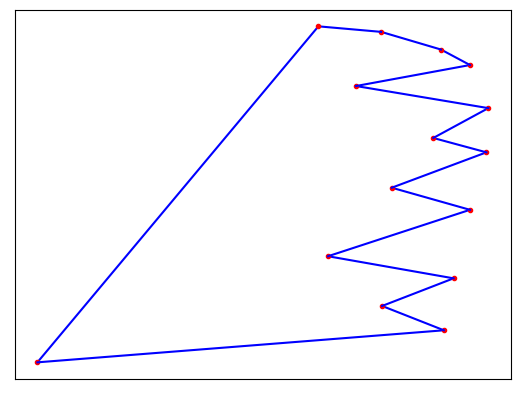

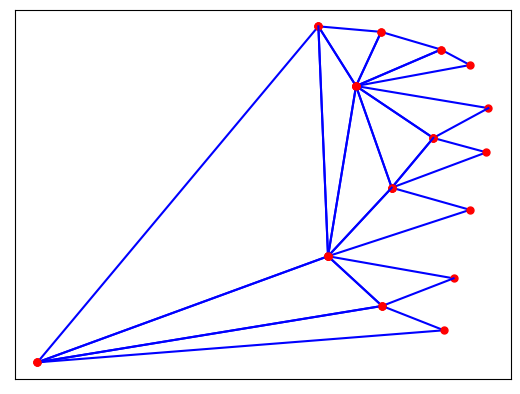

In [17]:
def Triangulate(random = True):
    
    L = read_from_file("tests/"+input("Nazwa pliku:")+".txt")
    steps = input("with steps? [Y/N]: ") in ['Y','y']
    Tr = Delunay(L)
    draw_figure(L)
    plt.show()
    Tr.start(steps,random)
Triangulate()

In [19]:
class Delunay:
    def __init__(self,T):
        ## 1
        self.FACES = set()
        self.Points = [Point(p[0],p[1]) for p in T]
        
        min_x = min([p.x for p in self.Points])
        min_y = min([p.y for p in self.Points])
        max_x = max([p.x for p in self.Points])
        max_y = max([p.y for p in self.Points])
        self.middle = Point((max_x+min_x)/2,(max_y+min_y)/2)
        width = max_x - min_x
        min_x -= width*0.1
        max_x += width*0.1
        height = max_y - min_y
        min_y -= height*0.1
        max_y += height*0.1
        A = Point(min_x,min_y)
        B = Point(max_x,min_y)
        C = Point(max_x,max_y)
        D = Point(min_x,max_y)
        self.startingPoints = [A,B,C,D]
        ## 2
        e1 = create_edge(A,B)
        e2 = create_edge(B,C)
        e3 = create_edge(C,A)
        T = [e1,e2,e3]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e2.twin,e1.twin)
        # ---------------
        self.middleFace = self.create_face(T)
        # ---------------
        e4 = create_edge(C,D)
        e5 = create_edge(D,A)
        T = [e3.twin,e4,e5]
        for i in range(3):
            connect_edges(T[i],T[(i+1)%3])
        connect_edges(e1.twin,e5.twin)
        connect_edges(e5.twin,e4.twin)
        connect_edges(e4.twin,e2.twin)
        
        self.create_face(T)
    
    def create_face(self,edges):
        face = Face(edges[0],edges[1],edges[2])
        for i in range(3):
            edges[i].face = face
        self.FACES.add(face)
        return face
    
    def pointInFace(self,face,p):
        for e in face.edges:
            if orient(e, p)<0:
                return False
        return True
        
    def findPoint(self,p):
        face = self.middleFace  #  na później
        while True:
            flag = True
            for e in face.edges:
                if orient(e, p)<0:
                    face = e.twin.face
                    flag = False
                    break
            if flag:
                break
        return face
    
    # Face musi miec pole VISITED
    def conditionFaces(self,p, face):
        faces = set()
        for f in self.FACES:
            f.visited = False
        Q = deque()
        Q.append(face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            face.visited = True
            if pointInCircle(face, p)>=0:
                faces.add(face)
                for e in face.edges:
                    if e.twin.face!=None and not e.twin.face.visited:
                        Q.append(e.twin.face)
        return faces
                
    #
    def combineFaces(self,faces):
        edges = set()
        for face in faces:
            if face == self.middleFace:
                self.middleFace = None
            edges.update(face.edges)
            self.FACES.remove(face)
        while len(edges) > 0:
            e = edges.pop()
            #print(e,e.twin in edges)
            if e.twin in edges:
                # usuwanie krawedzi
                e.twin.prev.next = e.next
                e.next.prev = e.twin.prev
                e.twin.next.prev = e.prev
                e.prev.next = e.twin.next
                edges.remove(e.twin)
                e.origin.edges.remove(e)
                e.twin.origin.edges.remove(e.twin)
            else:
                firstEdge = e
        return firstEdge
        
    #
    #face mhsi miec KRAWEDZIE, bo inaczej nie vedzie sie dalo dojsc z punktu do krawedzi (nie bedzie jednoznacznego okreslenia w ktore krawiedzie sa)
    def add_point(self,p): #zmiana, lecimy druga metoda
        plt.show()
        face = self.findPoint(p)
        
        faces = self.conditionFaces(p,face) # to ma być set zwrocony

        firstEdge=self.combineFaces(faces) # a tutaj jedna krawędź
        lastEdge = firstEdge.prev
            
        q = firstEdge.origin
        e = create_edge(p,q)
        e.next = firstEdge
        e.twin.prev = lastEdge #obaczymy czy trgo nie robie pozniei
        lastEdge.next = e.twin
        firstEdge.prev = e
        f = firstEdge.next
        while True:
            q = f.origin
                #podczepianie krawedzi
            e = create_edge(p,q)
            e.next = f
            e.twin.prev = f.prev 
            e.twin.next= e.twin.prev.prev
            e.twin.next.prev = e.twin     ########## TO OSTATNIE DOPISAŁEM
            #e.twin.next.prev = e.twin
            f.prev.next = e.twin
            f.prev = e
                #podczepianie sciany
            et = e.twin
            T = [et, et.next, et.prev]
            newFace = self.create_face(T)
            if self.middleFace == None:
                if self.pointInFace(newFace,self.middle):
                    self.middleFace = newFace
            if f == lastEdge:
                break
            f = f.next
        e.prev = lastEdge.next 
        e.prev.next = e
        T = [e, e.next, e.prev]
        
        newFace = self.create_face(T)
        if self.middleFace == None:
            if self.pointInFace(newFace,self.middle):
                self.middleFace = newFace
        
    def addPoints(self,steps):
        for p in self.Points: 
            self.add_point(p)
            if steps:
                draw_traingulation(self.FACES)
            
    def addPointsRandom(self,steps):
        POINTS = set(self.Points)
        while len(POINTS)>0:
            self.add_point(POINTS.pop())
            if steps:
                draw_traingulation(self.FACES)
                plt.show()
                
    # ----------------------
    
    def intersecting_edge(self,face,p,pnext):
        C,D = p, pnext
        edge2 = Edge(C)
        edge2.twin = Edge(D)
        for edge in face.edges:
            A = edge.origin
            B = edge.twin.origin
            if orient(edge,C)*orient(edge,D) > 0:
                continue
            if orient(edge2,A)*orient(edge2,B) <= 0:
                return edge
        return False
            
    def regainEdges(self,steps = False):
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            #print("p i next:  ",p,pnext)
            flag = False
            for e in p.edges:
                if e.twin in pnext.edges:
                    flag = True
                    break
            if not flag:
                
                dx = pnext.x - p.x
                dy = pnext.y - p.y
                lenght = dx**2+dy**2
                t = 10**(-8)
                pierw = 1
                while pierw*pierw<lenght:
                    pierw*=10
                    t/=10
                firstSearchPoint = Point(p.x+t*dx,p.y+t*dy)
                face = self.findPoint(firstSearchPoint)
                br = False
                while not br:
                    int_e = self.intersecting_edge(face, firstSearchPoint, pnext)
                    if int_e.face == self.middleFace or int_e.twin.face== self.middleFace:
                        self.middleFace = None
                    self.FACES.remove(int_e.face)
                    self.FACES.remove(int_e.twin.face)
                    
                    # usuniecie z punktow
                    int_e.origin.edges.remove(int_e)
                    int_e.twin.origin.edges.remove(int_e.twin)
                    
                    # usuniecie z sasiednich krawedzi
                    int_e.next.prev = int_e.twin.prev
                    int_e.prev.next = int_e.twin.next
                    int_e.twin.prev.next = int_e.next
                    int_e.twin.next.prev = int_e.prev

                    #tworzenie nowej
                    e1 = create_edge(int_e.prev.origin,int_e.twin.prev.origin)
                    
                    #podłaczanie
                    e1.origin.edges.add(e1)
                    e1.twin.origin.edges.add(e1.twin)
                    
                    # krawedzie
                    int_e.next.next = e1
                    e1.prev = int_e.next
                    int_e.twin.prev.prev = e1
                    e1.next = int_e.twin.prev
                    int_e.prev.prev = e1.twin
                    e1.twin.next = int_e.prev
                    int_e.twin.next.next = e1.twin
                    e1.twin.prev = int_e.twin.next
                    face1 = self.create_face([e1,e1.next,e1.prev])
                    face2 = self.create_face([e1.twin,e1.twin.next,e1.twin.prev])
                    if self.middleFace == None:
                        if self.pointInFace(face1,self.middle):
                            self.middleFace = face1
                        else:
                            self.middleFace = face2
                    face = e1.face
                    if self.intersecting_edge(face, firstSearchPoint, pnext) == False:
                        face = e1.twin.face
                    for e in p.edges:
                        if e.twin in pnext.edges:
                            br = True
                            break
                    if steps:
                        draw_traingulation(self.FACES)
                        plt.plot([int_e.origin.x,int_e.twin.origin.x],[int_e.origin.y,int_e.twin.origin.y],color = 'red')
                        plt.plot([e1.origin.x,e1.twin.origin.x],[e1.origin.y,e1.twin.origin.y],color = 'green')
                        plt.plot([p.x,pnext.x],[p.y,pnext.y],'--',color = "black")
                        plt.show()
                    
    def eraseOuterLayer(self,steps):
        def safe_create_edge(p,pnext):
            e1 = Edge(p)
            e2 = Edge(pnext)
            e1.twin = e2
            e2.twin = e1
            return e1
        EDGES = set()
        for i in range(len(self.Points)):
            p = self.Points[i]
            pnext = self.Points[(i+1)%len(self.Points)]
            e = safe_create_edge(p,pnext)
            EDGES.add(e)
        point = self.Points[0]
        for f in self.FACES:
            f.visited = False
        for e in point.edges:
            if e in EDGES:
                break
        Q = deque()
        Q.append(e.face)
        while Q:
            face = Q.popleft()
            if face.visited:
                continue
            if steps:
                ax = draw_traingulation(self.FACES)
                for f in self.FACES:
                    if f.visited:
                        pts = [[edge.origin.x,edge.origin.y] for edge in f.edges]
                        p = Polygon(pts, closed=False)
                        ax.add_patch(p)
                for edge in EDGES:
                    plt.plot([edge.origin.x,edge.twin.origin.x],[edge.origin.y,edge.twin.origin.y],linewidth = 5,color = 'black')
                pts = [[edge.origin.x,edge.origin.y] for edge in face.edges]
                p = Polygon(pts, closed=False,color = 'red')
                ax.add_patch(p)
                plt.show()
            face.visited = True
            for e in face.edges:
                if e not in EDGES and not e.twin.face.visited:
                    Q.append(e.twin.face)
        AllFaces = list(self.FACES)
        for face in AllFaces:
            #print(face)
            if face.visited:
                continue
            # usuwanie sciany
            for e in face.edges:
                e.next = None
                e.prev = None
                e.face = None
            self.FACES.remove(face)
    
    def start(self,Steps,random):
        if Steps:
            draw_traingulation(self.FACES)
            print("ADD")
        if random:
            self.addPointsRandom(steps = Steps)
        else:
            self.addPoints(steps = Steps)
        if Steps:
            print("REGAIN")
        self.regainEdges(steps = Steps)
        if Steps:
            draw_traingulation(self.FACES)
            plt.show()
            print("ERASE")
        self.eraseOuterLayer(steps = Steps)
        draw_traingulation(self.FACES)
        plt.show()